# Importing all neccessary packages

In [1]:

import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes

import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import requests # library to handle requests
import seaborn as sns
import folium # map rendering library

In [2]:
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values


## Developing with Foursquare API account

In [3]:
CLIENT_ID = '2BVQLADXQEEYCDWI1URSY0QP1UBVXSHLGIMH1CHYG3NRB4JL' # your Foursquare ID
CLIENT_SECRET = 'MXJKJMYGMGINZNR3WOWX5MSRNSHIYQM2VSIXYJJXZ2NOCNQ0' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 1000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2BVQLADXQEEYCDWI1URSY0QP1UBVXSHLGIMH1CHYG3NRB4JL
CLIENT_SECRET:MXJKJMYGMGINZNR3WOWX5MSRNSHIYQM2VSIXYJJXZ2NOCNQ0


#### Downloading the New york city data 

I manually downloaded data from https://geo.nyu.edu/catalog/nyu_2451_34572

##### Load the data

In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [5]:
list(newyork_data.keys())

['type', 'totalFeatures', 'features', 'crs', 'bbox']

In [6]:
newyork_data['features'][0:3]

[{'type': 'Feature',
  'id': 'nyu_2451_34572.1',
  'geometry': {'type': 'Point',
   'coordinates': [-73.84720052054902, 40.89470517661]},
  'geometry_name': 'geom',
  'properties': {'name': 'Wakefield',
   'stacked': 1,
   'annoline1': 'Wakefield',
   'annoline2': None,
   'annoline3': None,
   'annoangle': 0.0,
   'borough': 'Bronx',
   'bbox': [-73.84720052054902,
    40.89470517661,
    -73.84720052054902,
    40.89470517661]}},
 {'type': 'Feature',
  'id': 'nyu_2451_34572.2',
  'geometry': {'type': 'Point',
   'coordinates': [-73.82993910812398, 40.87429419303012]},
  'geometry_name': 'geom',
  'properties': {'name': 'Co-op City',
   'stacked': 2,
   'annoline1': 'Co-op',
   'annoline2': 'City',
   'annoline3': None,
   'annoangle': 0.0,
   'borough': 'Bronx',
   'bbox': [-73.82993910812398,
    40.87429419303012,
    -73.82993910812398,
    40.87429419303012]}},
 {'type': 'Feature',
  'id': 'nyu_2451_34572.3',
  'geometry': {'type': 'Point',
   'coordinates': [-73.82780644716412, 

In [7]:
# we only need features from New York data beacuse it has elevant information
neighbourhoods_data = newyork_data['features']


#### let's check the first element of the New York data

In [8]:
neighbourhoods_data[0]['properties']['borough']

'Bronx'

##### Define the new data frames columns

In [9]:
columns_names = ['Borough','Neighbourhood','Latitude','Longitude']

neighbourhoods = pd.DataFrame(columns = columns_names)
neighbourhoods

,Borough,Neighbourhood,Latitude,Longitude


##### loop through the data and fill the dataframe one row at a time

In [10]:
for data in neighbourhoods_data:
    borough = neighbourhood_name = data['properties']['borough'] 
    neighbourhood_name = data['properties']['name']
        
    neighbourhood_latlon = data['geometry']['coordinates']
    neighbourhood_lat = neighbourhood_latlon[1]
    neighbourhood_lon = neighbourhood_latlon[0]
    
    neighbourhoods = neighbourhoods.append({'Borough': borough,
                                          'Neighbourhood': neighbourhood_name,
                                          'Latitude': neighbourhood_lat,
                                         'Longitude': neighbourhood_lon}, ignore_index=True)
    

In [11]:
#check the data
neighbourhoods.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [12]:
#check the shape of data
neighbourhoods.shape

(306, 4)

## Create a map of New York with neighborhoods superimposed on top.

In [13]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [14]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(neighbourhoods['Latitude'], neighbourhoods['Longitude'], neighbourhoods['Borough'], neighbourhoods['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

##### let's findout unique borough

In [15]:
print('The dataframe has {} boroughs and {} neighbourhoods.'.format(
        len(neighbourhoods['Borough'].unique()),
        neighbourhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighbourhoods.


##### Now lets find out the names of boroughs of New York city

In [16]:
borough_name = neighbourhoods['Borough'].unique()
borough_name

array(['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island'],
      dtype=object)

##### lets find out the neighbourhood of borough

In [17]:
manhattan_data = neighbourhoods[neighbourhoods['Borough'] == 'Manhattan'].reset_index(drop = True)
manhattan_data.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


#### creating a getNearby function to find out all Indian restaurent in a neighbourhood

In [18]:
def getNearbyVenues(names, latitudes, longitudes, borough, radius=600):
    search_query = 'Indian'
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        #print(len(results))
        
        # return only relevant information for each nearby venue
        
        cat_list= [(name, lat,lng, v['name'], v['location']['lat'], v['location']['lng'],borough) for v in results]
        
        venues_list.append(cat_list)

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Borough']
    
    return(nearby_venues)

In [19]:


manhattan_venues = getNearbyVenues(names=manhattan_data['Neighbourhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude'],
                                   borough='Manhattan'
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [20]:
print(manhattan_venues.shape)
manhattan_venues.head()

(232, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Borough
0,Marble Hill,40.876551,-73.910660,Riverdale Indian Cuisine,40.880886,-73.908800,Manhattan
1,Chinatown,40.715618,-73.994279,American Indian Community House,40.715691,-73.993469,Manhattan
2,Chinatown,40.715618,-73.994279,Indian Restaurant,40.719978,-73.995903,Manhattan
3,Chinatown,40.715618,-73.994279,Curry House Indian Cuisine,40.719864,-73.990425,Manhattan
4,Chinatown,40.715618,-73.994279,Chili's Indian Cusine,40.719720,-73.990134,Manhattan


##### Here counting Indian restaurants in the Manhattan neighbourhoods

In [21]:
manhattan_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Borough
Neighbourhood,,,,,,
Battery Park City,4,4,4,4,4,4
Carnegie Hill,3,3,3,3,3,3
Central Harlem,1,1,1,1,1,1
Chelsea,2,2,2,2,2,2
Chinatown,6,6,6,6,6,6
Civic Center,10,10,10,10,10,10
Clinton,7,7,7,7,7,7
East Harlem,2,2,2,2,2,2
East Village,14,14,14,14,14,14


##### creating a for loop for finding all Indian restaurants in all boroughs in New York city

In [22]:
indian_res = []

for borough in borough_name:
    #filtering neighbourhood data for borough
    borough_data = neighbourhoods[neighbourhoods['Borough'] == borough].reset_index(drop = True)
    
    #finding indian restaurent near a boroughs all neighbourhoods
    borough_venues = getNearbyVenues(names=borough_data['Neighbourhood'],
                                   latitudes=borough_data['Latitude'],
                                   longitudes=borough_data['Longitude'],borough=borough
                                  )
    indian_res.append(borough_venues)
    

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Claremont Village
Concourse Village
Mount Eden
Mount Hope
Bronxdale
Allerton
Kingsbridge Heights
Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery 

Merging all the data frame of all boroughs 

In [23]:
restaurent_df = pd.concat(indian_res)

In [24]:
restaurent_df.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Borough
0,Wakefield,40.894705,-73.847201,Jackie's West Indian Bakery,40.889283,-73.843310,Bronx
1,Eastchester,40.887556,-73.827806,S.Y. West Indian Supermarket,40.883976,-73.831772,Bronx
2,Eastchester,40.887556,-73.827806,Foodz to go,40.889722,-73.830990,Bronx
3,Fieldston,40.895437,-73.905643,Indian Pond,40.893726,-73.907808,Bronx
4,Riverdale,40.890834,-73.912585,Indian Pond,40.893726,-73.907808,Bronx


In [25]:
restaurent_df.shape

(387, 7)

## Visualise number of Indian restaurants in each borough

In [26]:
res_borough = restaurent_df.groupby('Borough').Venue.agg('count').to_frame('total_indian_res').reset_index()
res_borough

,Borough,total_indian_res
0,Bronx,24
1,Brooklyn,85
2,Manhattan,232
3,Queens,37
4,Staten Island,9


###### visualing with the help of seaborn bar plot

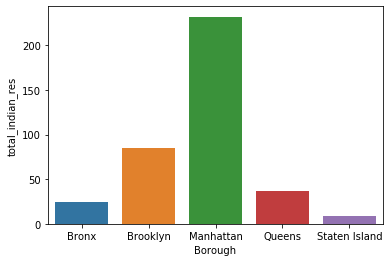

In [27]:
ax = sns.barplot(x="Borough", y="total_indian_res", data=res_borough)

##### counting the Indian restaurants in each neighbourhood

In [28]:
res_count = restaurent_df.groupby('Neighbourhood').Venue.agg('count').to_frame('total').reset_index()
res_count

,Neighbourhood,total
0,Allerton,1
1,Astoria,4
2,Battery Park City,4
3,Bayside,2
4,Boerum Hill,4
5,Briarwood,3
6,Broadway Junction,1
7,Bronxdale,1
8,Brooklyn Heights,4
9,Brownsville,1


In [29]:
 res_count.sort_values(by = ['total'],ascending=False)
    

,Neighbourhood,total
65,Midtown South,19
71,Noho,18
34,Financial District,15
27,East Village,14
64,Midtown,14
99,Sutton Place,13
16,Civic Center,10
47,Greenwich Village,10
44,Gramercy,10
69,Murray Hill,9


In [30]:
res_count['Neighbourhood'].shape

(116,)

#### Downloading population data(2010) of New York city

In [31]:
ny_pop = pd.read_csv ('New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv')
ny_pop.head()

,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population
0,Bronx,2000,5,BX01,Claremont-Bathgate,28149
1,Bronx,2000,5,BX03,Eastchester-Edenwald-Baychester,35422
2,Bronx,2000,5,BX05,Bedford Park-Fordham North,55329
3,Bronx,2000,5,BX06,Belmont,25967
4,Bronx,2000,5,BX07,Bronxdale,34309


In [32]:
ny_pop = ny_pop.rename(columns={'NTA Name': 'Neighbourhood'})


In [33]:
ny_pop['Neighbourhood'].unique().shape

(195,)

In [34]:
ny_pop =  ny_pop[ny_pop['Year']==2010]

#### Merging the population data with the Indian restaurants data in neighbourhood

In [35]:
comp_data= pd.merge(res_count, ny_pop, on = 'Neighbourhood')
comp_data.head()

,Neighbourhood,total,Borough,Year,FIPS County Code,NTA Code,Population
0,Astoria,4,Queens,2010,81,QN70,78793
1,Bronxdale,1,Bronx,2010,5,BX07,35538
2,Brownsville,1,Brooklyn,2010,47,BK81,58300
3,Cambria Heights,1,Queens,2010,81,QN33,18677
4,Chinatown,6,Manhattan,2010,61,MN27,47844


## Merging the population data with the New York city data in neighbourhood

In [36]:
merg_data = pd.merge(neighbourhoods,ny_pop, on = ['Neighbourhood', 'Borough'] )
merg_data.head()

,Borough,Neighbourhood,Latitude,Longitude,Year,FIPS County Code,NTA Code,Population
0,Bronx,Norwood,40.877224,-73.879391,2010,5,BX43,40494
1,Bronx,Pelham Parkway,40.857413,-73.854756,2010,5,BX49,30073
2,Bronx,East Tremont,40.842696,-73.887356,2010,5,BX17,43423
3,Bronx,Longwood,40.815099,-73.895788,2010,5,BX33,26196
4,Bronx,Hunts Point,40.809730,-73.883315,2010,5,BX27,27204


## creating a map of New York city population

In [37]:
# create map of New York using latitude and longitude values
map_newyork_pop = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, population, neighbourhood in zip(merg_data['Latitude'], merg_data['Longitude'], merg_data['Population'], merg_data['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, population)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork_pop)  
    
map_newyork_pop

In [38]:
comp_data.sort_values(by = ['total'],ascending=False)

,Neighbourhood,total,Borough,Year,FIPS County Code,NTA Code,Population
8,East Village,14,Manhattan,2010,61,MN22,44136
14,Gramercy,10,Manhattan,2010,61,MN21,27988
23,Murray Hill,9,Queens,2010,81,QN51,51739
5,Clinton,7,Manhattan,2010,61,MN15,45884
4,Chinatown,6,Manhattan,2010,61,MN27,47844
34,Upper West Side,5,Manhattan,2010,61,MN12,132378
0,Astoria,4,Queens,2010,81,QN70,78793
35,West Village,4,Manhattan,2010,61,MN23,66880
31,Richmond Hill,4,Queens,2010,81,QN54,62982
26,Ozone Park,4,Queens,2010,81,QN56,21376


In [39]:
comp_data.shape

(39, 7)

##### Finding out Indian restaurant density(size of population for one restaurant)

In [40]:
comp_data['ratio']= comp_data['Population']/comp_data['total']


In [41]:
comp_data.head()

,Neighbourhood,total,Borough,Year,FIPS County Code,NTA Code,Population,ratio
0,Astoria,4,Queens,2010,81,QN70,78793,19698.25
1,Bronxdale,1,Bronx,2010,5,BX07,35538,35538.00
2,Brownsville,1,Brooklyn,2010,47,BK81,58300,58300.00
3,Cambria Heights,1,Queens,2010,81,QN33,18677,18677.00
4,Chinatown,6,Manhattan,2010,61,MN27,47844,7974.00


In [42]:
comp_data.sort_values(by = ['ratio'],ascending=False)

,Neighbourhood,total,Borough,Year,FIPS County Code,NTA Code,Population,ratio
7,East New York,1,Brooklyn,2010,47,BK82,91958,91958.000000
33,South Ozone Park,1,Queens,2010,81,QN55,75878,75878.000000
19,Lower East Side,1,Manhattan,2010,61,MN28,72957,72957.000000
12,Flatlands,1,Brooklyn,2010,47,BK58,64762,64762.000000
2,Brownsville,1,Brooklyn,2010,47,BK81,58300,58300.000000
21,Morningside Heights,1,Manhattan,2010,61,MN09,55929,55929.000000
30,Queens Village,1,Queens,2010,81,QN34,52504,52504.000000
22,Mount Hope,1,Bronx,2010,5,BX41,51807,51807.000000
16,Hamilton Heights,1,Manhattan,2010,61,MN04,48520,48520.000000
17,Homecrest,1,Brooklyn,2010,47,BK25,44316,44316.000000


#### Top 5 neighbourhoods in Brooklyn where Indian restaurant can be open

In [43]:
Brooklyn_data = comp_data[comp_data['Borough'] == 'Brooklyn'].reset_index(drop = True)
Brooklyn_data.head()

,Neighbourhood,total,Borough,Year,FIPS County Code,NTA Code,Population,ratio
0,Brownsville,1,Brooklyn,2010,47,BK81,58300,58300.000000
1,Clinton Hill,3,Brooklyn,2010,47,BK69,34791,11597.000000
2,East New York,1,Brooklyn,2010,47,BK82,91958,91958.000000
3,East Williamsburg,2,Brooklyn,2010,47,BK90,34158,17079.000000
4,Erasmus,3,Brooklyn,2010,47,BK95,29938,9979.333333


In [44]:
Brooklyn_data = Brooklyn_data.sort_values(by = ['ratio'],ascending=False)
Brooklyn_data.head()

,Neighbourhood,total,Borough,Year,FIPS County Code,NTA Code,Population,ratio
2,East New York,1,Brooklyn,2010,47,BK82,91958,91958.0
6,Flatlands,1,Brooklyn,2010,47,BK58,64762,64762.0
0,Brownsville,1,Brooklyn,2010,47,BK81,58300,58300.0
8,Homecrest,1,Brooklyn,2010,47,BK25,44316,44316.0
5,Flatbush,3,Brooklyn,2010,47,BK42,105804,35268.0


##### Top 5 neighbourhoods in Manhattan where Indian restaurant can be open

In [45]:
manhattan_data = comp_data[comp_data['Borough'] == 'Manhattan'].reset_index(drop = True)
manhattan_data.head()

,Neighbourhood,total,Borough,Year,FIPS County Code,NTA Code,Population,ratio
0,Chinatown,6,Manhattan,2010,61,MN27,47844,7974.000000
1,Clinton,7,Manhattan,2010,61,MN15,45884,6554.857143
2,East Village,14,Manhattan,2010,61,MN22,44136,3152.571429
3,Gramercy,10,Manhattan,2010,61,MN21,27988,2798.800000
4,Hamilton Heights,1,Manhattan,2010,61,MN04,48520,48520.000000


In [46]:
manhattan_data = manhattan_data.sort_values(by = ['ratio'],ascending=False)
manhattan_data.head()

,Neighbourhood,total,Borough,Year,FIPS County Code,NTA Code,Population,ratio
5,Lower East Side,1,Manhattan,2010,61,MN28,72957,72957.000000
7,Morningside Heights,1,Manhattan,2010,61,MN09,55929,55929.000000
4,Hamilton Heights,1,Manhattan,2010,61,MN04,48520,48520.000000
8,Upper West Side,5,Manhattan,2010,61,MN12,132378,26475.600000
10,Yorkville,3,Manhattan,2010,61,MN32,77942,25980.666667


###### Top 5 neighbourhoods in Staten Island where Indian restaurant can be open

In [47]:
staten_Island_data = comp_data[comp_data['Borough'] == 'Staten Island'].reset_index(drop = True)
staten_Island_data.head()

,Neighbourhood,total,Borough,Year,FIPS County Code,NTA Code,Population,ratio
0,Great Kills,1,Staten Island,2010,85,SI54,40720,40720.0
1,Port Richmond,2,Staten Island,2010,85,SI28,20191,10095.5
2,Westerleigh,1,Staten Island,2010,85,SI07,24102,24102.0


In [48]:
staten_Island_data = staten_Island_data.sort_values(by = ['ratio'],ascending=False)
staten_Island_data.head()

,Neighbourhood,total,Borough,Year,FIPS County Code,NTA Code,Population,ratio
0,Great Kills,1,Staten Island,2010,85,SI54,40720,40720.0
2,Westerleigh,1,Staten Island,2010,85,SI07,24102,24102.0
1,Port Richmond,2,Staten Island,2010,85,SI28,20191,10095.5


###### Top 5 neighbourhoods in Queens where Indian restaurant can be open

In [49]:
queens_data = comp_data[comp_data['Borough'] == 'Queens'].reset_index(drop = True)
queens_data.head()

,Neighbourhood,total,Borough,Year,FIPS County Code,NTA Code,Population,ratio
0,Astoria,4,Queens,2010,81,QN70,78793,19698.250000
1,Cambria Heights,1,Queens,2010,81,QN33,18677,18677.000000
2,Kew Gardens,2,Queens,2010,81,QN60,23278,11639.000000
3,Murray Hill,9,Queens,2010,81,QN51,51739,5748.777778
4,Ozone Park,4,Queens,2010,81,QN56,21376,5344.000000


In [50]:
queens_data = queens_data.sort_values(by = ['ratio'],ascending=False)
queens_data.head()

,Neighbourhood,total,Borough,Year,FIPS County Code,NTA Code,Population,ratio
8,South Ozone Park,1,Queens,2010,81,QN55,75878,75878.00
5,Queens Village,1,Queens,2010,81,QN34,52504,52504.00
7,South Jamaica,1,Queens,2010,81,QN01,38894,38894.00
0,Astoria,4,Queens,2010,81,QN70,78793,19698.25
1,Cambria Heights,1,Queens,2010,81,QN33,18677,18677.00


###### Top 5 neighbourhoods in Bronx where Indian restaurant can be open

In [51]:
bronx_data = comp_data[comp_data['Borough'] == 'Bronx'].reset_index(drop = True)
bronx_data.head()

,Neighbourhood,total,Borough,Year,FIPS County Code,NTA Code,Population,ratio
0,Bronxdale,1,Bronx,2010,5,BX07,35538,35538.0
1,Mount Hope,1,Bronx,2010,5,BX41,51807,51807.0
2,Norwood,1,Bronx,2010,5,BX43,40494,40494.0
3,Pelham Parkway,1,Bronx,2010,5,BX49,30073,30073.0


In [52]:
bronx_data = bronx_data.sort_values(by = ['ratio'],ascending=False)
bronx_data.head()

,Neighbourhood,total,Borough,Year,FIPS County Code,NTA Code,Population,ratio
1,Mount Hope,1,Bronx,2010,5,BX41,51807,51807.0
2,Norwood,1,Bronx,2010,5,BX43,40494,40494.0
0,Bronxdale,1,Bronx,2010,5,BX07,35538,35538.0
3,Pelham Parkway,1,Bronx,2010,5,BX49,30073,30073.0
